In [ ]:
%pip install "lime>=0.2.0.1" \
             "pandas>=2.3.2" \
             "scikit-learn>=1.7.2" \
             "shap>=0.48.0" \
             "numpy<=2.2"

%pip install "ipykernel>=6.30.1"

# Train original model

In [6]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
import pandas as pd


data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns, index=X_test.index)

model = LinearRegression()
model.fit(X_train, y_train)
    

y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}, R²: {r2:.3f}")


RMSE: 0.727, R²: 0.594


# Picking a random sample to explain

In [ ]:
def get_random_instance(y, X, model, 
                        percentile=0.95, above=True, random_state=0):
    p = y.quantile(percentile)
    subset = y[y >= p] if above else y[y <= p]
    random_instance = subset.sample(n=1, random_state=random_state)
    
    idx = random_instance.index[0]
    true_val = random_instance.values[0]
    pred_val = model.predict(X.loc[[idx]])[0]
    
    return {
        "idx": idx,
        "true_val": true_val,
        "pred_val": pred_val,
        "percentile_value": p
    }


def show_random_instance(instance_dict, percentile=95, label="instance"):
    print(f"\n{percentile}th percentile of y_test: {instance_dict['percentile_value']:.3f}")
    print(f"Random {label}:")
    print(f"  Index: {instance_dict['idx']}")
    print(f"  True value: {instance_dict['true_val']:.3f}")
    print(f"  Predicted value: {instance_dict['pred_val']:.3f}")
    
sample = get_random_instance(y_test, X_test, model, percentile=0.95, above=True)
sample["label"] = "sample instance"
show_random_instance(sample, percentile=95, label=sample["label"])

# LIME Explanation

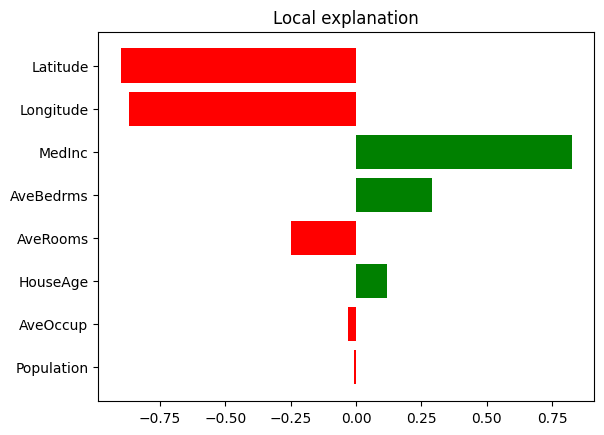

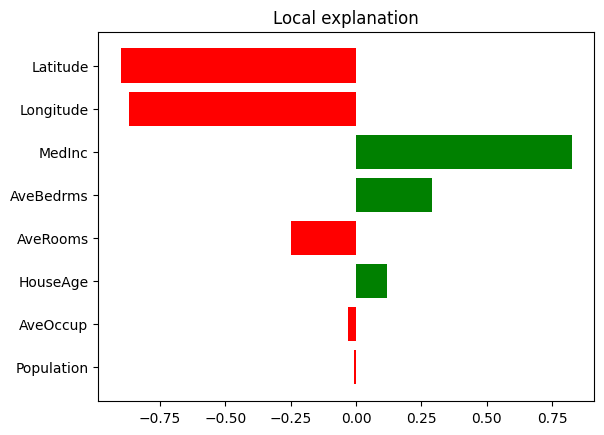

In [17]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np


explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    mode="regression",
    discretize_continuous=False, # TODO: try True
    sample_around_instance=True,
    kernel_width=0.75*np.sqrt(X_train.shape[1]),
    random_state=0
)


def predict_fn(X_array):
    X_df = pd.DataFrame(X_array, columns=X_train.columns)
    return model.predict(X_df)

exp = explainer.explain_instance(
    data_row=X_test.loc[[sample["idx"]]].to_numpy()[0],
    predict_fn=predict_fn,
    num_features=10,
    num_samples=3000,
    distance_metric='euclidean'
)

exp.as_pyplot_figure()

# SHAP Explanation

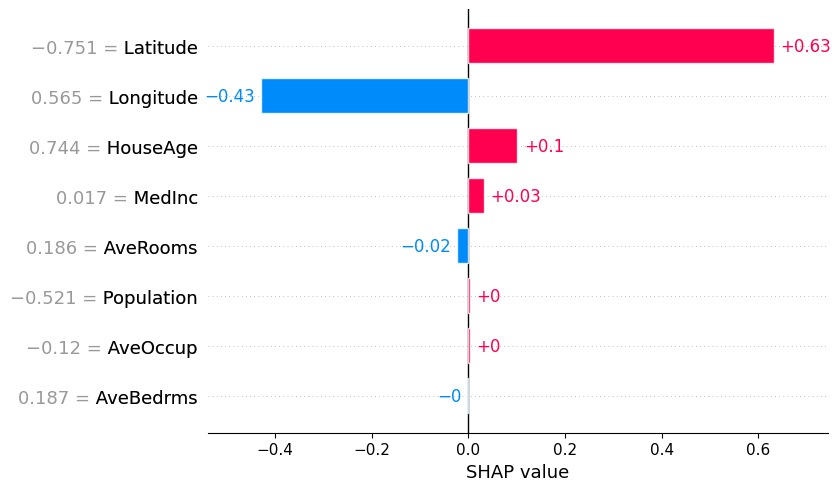

In [ ]:
import shap


background = shap.utils.sample(X_train, 100, random_state=0)
exp = shap.LinearExplainer(model, background)

X_sub = shap.utils.sample(X_test, 300, random_state=0)
shap_values = exp(X_sub)

sample_features = X_test.loc[[sample["idx"]],:]
local_exp = exp(sample_features)
shap.plots.bar(local_exp[0])
